/home/tk/.virtualenvs/agent-room-env-v2-qa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


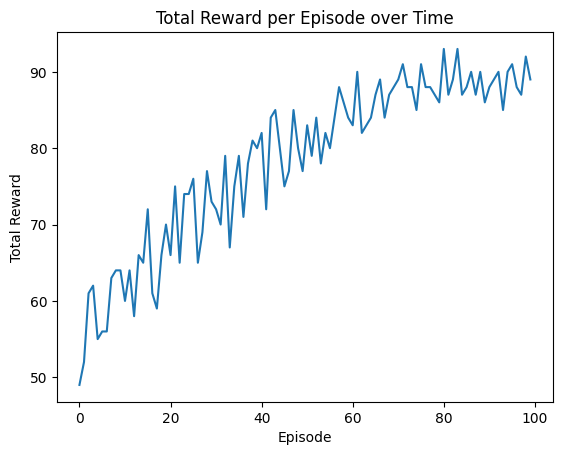

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from tqdm.auto import tqdm

# Initialize parameters
num_actions = 20
num_features = 10
N = 100  # Number of episodes
M = 100  # Number of contexts per episode

# Initialize alpha and beta parameters for each action and feature
alpha = np.ones((num_actions, num_features))
beta_params = np.ones((num_actions, num_features))

# True weights for each action (this is what the agent should learn to approximate)
true_weights = np.random.randn(num_actions, num_features)

# Generate a fixed set of base context vectors before training
base_contexts = np.random.randn(M, num_features)

# Function to generate reward based on the true weights and context
def generate_reward(action, context):
    true_mean = np.dot(true_weights[action], context)
    noise = np.random.normal(0, 0.2)  # Reduced noise
    return 1 if true_mean + noise > 0 else 0

# Function to select an action based on Thompson Sampling
def select_action(alpha, beta_params, context):
    sampled_values = np.zeros(num_actions)
    for action in range(num_actions):
        # Ensure alpha and beta are valid by clipping to a small positive value
        alpha_sum = np.clip(alpha[action].sum(), 1e-5, None)
        beta_sum = np.clip(beta_params[action].sum(), 1e-5, None)
        
        # Sample the probability from Beta distribution
        sampled_prob = beta(alpha_sum, beta_sum).rvs()
        
        # Use the dot product of the sampled probability and the context as an estimate of expected reward
        sampled_values[action] = sampled_prob * np.dot(alpha[action], context)
    
    return np.argmax(sampled_values)

# Function to update the alpha and beta parameters
def update_params(chosen_action, reward, context, alpha, beta_params):
    # Update alpha and beta using a smaller step to smooth learning
    if reward == 1:
        alpha[chosen_action] += 0.001 * context
    else:
        beta_params[chosen_action] += 0.001 * context

# Initialize episode rewards storage
episode_rewards = []

# Simulate N episodes
np.random.seed(42)
for episode in tqdm(range(N)):
    total_reward = 0  # Total reward for the episode
    
    for context_num in range(M):
        # Add small noise to the base context vector to simulate variability
        context = base_contexts[context_num] + np.random.normal(0, 0.01, num_features)
        
        # Select action based on the current alpha and beta parameters
        chosen_action = select_action(alpha, beta_params, context)

        # Generate reward based on the true underlying weights
        reward = generate_reward(chosen_action, context)

        # Update the alpha and beta parameters based on the observed reward
        update_params(chosen_action, reward, context, alpha, beta_params)

        # Accumulate the reward for this episode
        total_reward += reward
    
    # Store the total reward for the current episode
    episode_rewards.append(total_reward)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode over Time')
plt.show()


100%|██████████| 200/200 [00:24<00:00,  8.32it/s]


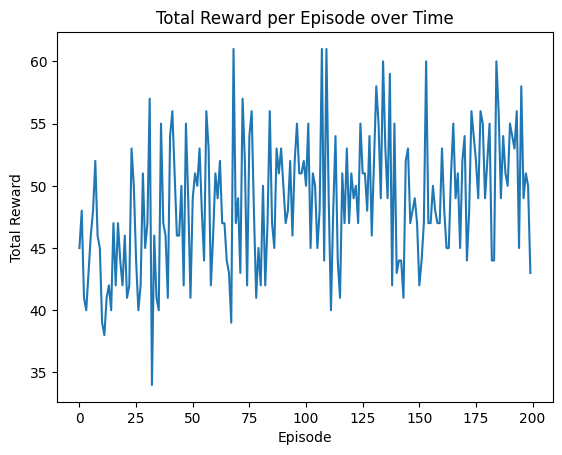

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from tqdm.auto import tqdm

# Initialize parameters
num_features = 20
K = 5  # Maximum number of vectors per context (actions)
N_episodes = 200  # Number of episodes
M = 100  # Number of steps per episode

# Generate a large set of base context vectors
base_contexts = np.random.randn(100, num_features)

# Initialize alpha and beta parameters for each action and feature
# Alpha and beta are dynamic, updated based on selected action at each step
alpha = np.ones(num_features)
beta_params = np.ones(num_features)

# True weights for each action (this is what the agent should learn to approximate)
true_weights = np.random.randn(1000, num_features)  # A set of true weights for each base context

# Function to generate reward based on the true weights and context
def generate_reward(action, context):
    true_mean = np.dot(true_weights[action], context)
    noise = np.random.normal(0, 0.01)  # Add some noise
    return 1 if true_mean + noise > 0 else 0

# Function to select an action based on Thompson Sampling from the available context vectors
def select_action(alpha, beta_params, contexts):
    num_actions = contexts.shape[0]  # The number of context vectors (actions) available
    sampled_values = np.zeros(num_actions)
    
    for action in range(num_actions):
        # Sample the probability from Beta distribution for this action
        alpha_sum = np.clip(alpha.sum(), 1e-5, None)
        beta_sum = np.clip(beta_params.sum(), 1e-5, None)
        
        # Sample the probability for this action
        sampled_prob = beta(alpha_sum, beta_sum).rvs()
        
        # Estimate expected reward using the sampled probability and the context
        sampled_values[action] = sampled_prob * np.dot(alpha, contexts[action])
    
    return np.argmax(sampled_values)

# Function to update the alpha and beta parameters
def update_params(chosen_action, reward, context, alpha, beta_params):
    if reward == 1:
        alpha += 0.001 * context
    else:
        beta_params += 0.001 * context

# Initialize episode rewards storage
episode_rewards = []

# Simulate N episodes
np.random.seed(42)
for episode in tqdm(range(N_episodes)):
    total_reward = 0  # Total reward for the episode
    
    for step in range(M):
        # Randomly generate the number of available context vectors (actions)
        num_actions = np.random.randint(1, K + 1)  # Randomly select between 1 to K actions
        
        # Randomly select context indices from the base contexts
        chosen_context_indices = np.random.choice(base_contexts.shape[0], num_actions, replace=False)
        
        # Add small noise to the base context vectors to simulate variability
        contexts = base_contexts[chosen_context_indices] + np.random.normal(0, 0.01, (num_actions, num_features))
        
        # Select action based on the current alpha and beta parameters
        chosen_action_index = select_action(alpha, beta_params, contexts)

        # Map the chosen action index back to the original action in base_contexts
        chosen_action = chosen_context_indices[chosen_action_index]

        # Generate reward based on the true underlying weights of the chosen action
        reward = generate_reward(chosen_action, contexts[chosen_action_index])

        # Update the alpha and beta parameters based on the observed reward
        update_params(chosen_action, reward, contexts[chosen_action_index], alpha, beta_params)

        # Accumulate the reward for this episode
        total_reward += reward
    
    # Store the total reward for the current episode
    episode_rewards.append(total_reward)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode over Time')
plt.show()


100%|██████████| 200/200 [00:15<00:00, 13.00it/s]


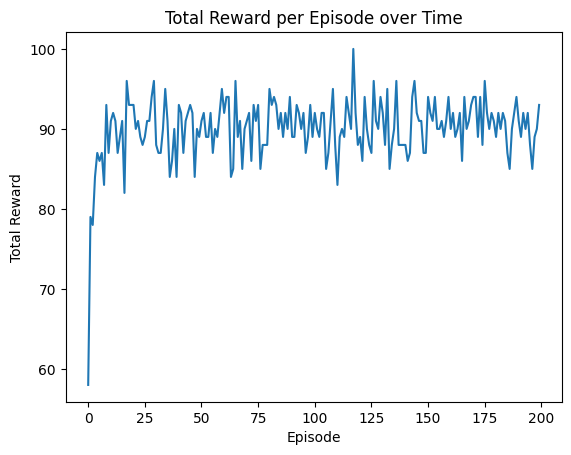

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Initialize parameters
num_features = 20
K = 20  # Maximum number of vectors per context (actions)
N_episodes = 200  # Number of episodes
M = 100  # Number of steps per episode

# Generate a large set of base context vectors (move to device)
base_contexts = torch.tensor(np.random.randn(100, num_features), dtype=torch.float32, device=device)

# True weights for each action (move to device)
true_weights = torch.tensor(np.random.randn(1000, num_features), dtype=torch.float32, device=device)

# Define the MLP Model
class BanditMLP(nn.Module):
    def __init__(self, input_size):
        super(BanditMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Hidden layer with 64 neurons
        self.fc2 = nn.Linear(64, 32)  # Another hidden layer with 32 neurons
        self.fc3 = nn.Linear(32, 1)  # Output layer: predicts probability of reward
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output between 0 and 1 (probability)
        return x

# Initialize the MLP model
model = BanditMLP(input_size=num_features).to(device)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary rewards
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to generate reward based on the true weights and context
def generate_reward(action, context):
    true_mean = torch.dot(true_weights[action], context)
    noise = torch.normal(0, 0.01, size=(1,)).to(device)  # Add some noise
    return 1 if true_mean + noise > 0 else 0

# Function to select an action based on MLP predictions (epsilon-greedy)
def select_action(model, contexts, epsilon=0.1):
    num_actions = contexts.shape[0]
    
    # Epsilon-greedy strategy: explore with probability epsilon, otherwise exploit
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Explore: choose a random action
    else:
        # Exploit: choose the action with the highest predicted reward
        with torch.no_grad():
            predictions = model(contexts)  # Predict reward probabilities for each action
        return torch.argmax(predictions).item()

# Training the model (update weights based on observed reward)
def train_model(model, optimizer, contexts, chosen_action_index, reward):
    model.train()
    
    # Get the context for the chosen action
    chosen_context = contexts[chosen_action_index].unsqueeze(0)  # Add batch dimension
    
    # Forward pass: predict the probability of reward for the chosen context
    predicted_reward = model(chosen_context)
    
    # Convert reward to tensor and compute loss
    reward_tensor = torch.tensor([[reward]], dtype=torch.float32, device=device)
    loss = criterion(predicted_reward, reward_tensor)
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize episode rewards storage
episode_rewards = []

# Simulate N episodes
torch.manual_seed(42)
np.random.seed(42)
for episode in tqdm(range(N_episodes)):
    total_reward = 0  # Total reward for the episode
    
    for step in range(M):
        # Randomly generate the number of available context vectors (actions)
        num_actions = np.random.randint(1, K + 1)  # Randomly select between 1 to K actions
        
        # Randomly select context indices from the base contexts
        chosen_context_indices = np.random.choice(base_contexts.shape[0], num_actions, replace=False)
        
        # Add small noise to the base context vectors to simulate variability
        contexts = base_contexts[chosen_context_indices] + torch.normal(0, 0.01, size=(num_actions, num_features)).to(device)
        
        # Select action based on MLP predictions using epsilon-greedy strategy
        chosen_action_index = select_action(model, contexts)

        # Map the chosen action index back to the original action in base_contexts
        chosen_action = chosen_context_indices[chosen_action_index]

        # Generate reward based on the true underlying weights of the chosen action
        reward = generate_reward(chosen_action, contexts[chosen_action_index])

        # Train the MLP model using the chosen context and observed reward
        train_model(model, optimizer, contexts, chosen_action_index, reward)

        # Accumulate the reward for this episode
        total_reward += reward
    
    # Store the total reward for the current episode
    episode_rewards.append(total_reward)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode over Time')
plt.show()


100%|██████████| 200/200 [00:20<00:00,  9.64it/s]


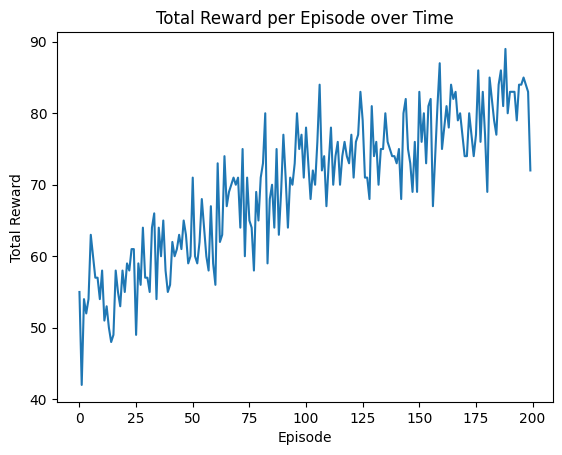

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from collections import deque

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize parameters
num_features = 20
K = 1000  # Maximum number of vectors per context (actions)
N_episodes = 200  # Number of episodes
M = 100  # Number of steps per episode
batch_size = 32  # Batch size for replay buffer sampling
buffer_size = 1000  # Size of the replay buffer

# Generate a large set of base context vectors (move to device)
base_contexts = torch.tensor(np.random.randn(K, num_features), dtype=torch.float32, device=device)

# True weights for each action (move to device)
true_weights = torch.tensor(np.random.randn(K, num_features), dtype=torch.float32, device=device)

# Define the MLP Model
class BanditMLP(nn.Module):
    def __init__(self, input_size):
        super(BanditMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Hidden layer with 64 neurons
        self.fc2 = nn.Linear(64, 32)  # Another hidden layer with 32 neurons
        self.fc3 = nn.Linear(32, 1)  # Output layer: predicts probability of reward
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output between 0 and 1 (probability)
        return x

# Initialize the MLP model
model = BanditMLP(input_size=num_features).to(device)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary rewards
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Replay buffer to store experiences
replay_buffer = deque(maxlen=buffer_size)

# Function to generate reward based on the true weights and context
def generate_reward(action, context):
    true_mean = torch.dot(true_weights[action], context)
    noise = torch.normal(0, 0.01, size=(1,)).to(device)  # Add some noise
    return 1 if true_mean + noise > 0 else 0

# Function to select an action based on MLP predictions (epsilon-greedy)
def select_action(model, contexts, epsilon=0.1):
    num_actions = contexts.shape[0]
    
    # Epsilon-greedy strategy: explore with probability epsilon, otherwise exploit
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Explore: choose a random action
    else:
        # Exploit: choose the action with the highest predicted reward
        with torch.no_grad():
            predictions = model(contexts)  # Predict reward probabilities for each action
        return torch.argmax(predictions).item()

# Function to train the MLP model using a batch of experiences from the replay buffer
def train_model_batch(model, optimizer, replay_buffer):
    if len(replay_buffer) < batch_size:
        return  # Don't train until the buffer is filled enough
    
    # Sample a batch of experiences
    batch = random.sample(replay_buffer, batch_size)
    
    # Extract context, action, and reward from the batch
    batch_contexts = torch.stack([experience[0] for experience in batch]).to(device)
    batch_actions = torch.tensor([experience[1] for experience in batch], dtype=torch.long, device=device)
    batch_rewards = torch.tensor([experience[2] for experience in batch], dtype=torch.float32, device=device)
    
    # Forward pass: predict rewards for each action in the batch
    model.train()
    predicted_rewards = model(batch_contexts)
    
    # Compute loss between predicted rewards and actual rewards
    loss = criterion(predicted_rewards, batch_rewards.unsqueeze(1))  # Unsqueeze to match dimensions
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize episode rewards storage
episode_rewards = []

# Epsilon parameters for decay
epsilon = 1.0  # Start with high exploration
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Decay factor per episode

# Simulate N episodes
torch.manual_seed(42)
np.random.seed(42)
for episode in tqdm(range(N_episodes)):
    total_reward = 0  # Total reward for the episode
    
    for step in range(M):
        # Randomly generate the number of available context vectors (actions)
        num_actions = np.random.randint(1, K + 1)  # Randomly select between 1 to K actions
        
        # Randomly select context indices from the base contexts
        chosen_context_indices = np.random.choice(base_contexts.shape[0], num_actions, replace=False)
        
        # Add small noise to the base context vectors to simulate variability
        contexts = base_contexts[chosen_context_indices] + torch.normal(0, 0.01, size=(num_actions, num_features)).to(device)
        
        # Select action based on MLP predictions using epsilon-greedy strategy
        chosen_action_index = select_action(model, contexts, epsilon)

        # Map the chosen action index back to the original action in base_contexts
        chosen_action = chosen_context_indices[chosen_action_index]

        # Generate reward based on the true underlying weights of the chosen action
        reward = generate_reward(chosen_action, contexts[chosen_action_index])

        # Store the experience in the replay buffer (store the entire context and reward)
        replay_buffer.append((contexts[chosen_action_index], reward, torch.tensor([reward], device=device)))

        # Accumulate the reward for this episode
        total_reward += reward
        
        # Train the MLP model using a batch of experiences from the replay buffer
        train_model_batch(model, optimizer, replay_buffer)
    
    # Store the total reward for the current episode
    episode_rewards.append(total_reward)
    
    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode over Time')
plt.show()


100%|██████████| 1000/1000 [01:26<00:00, 11.50it/s]


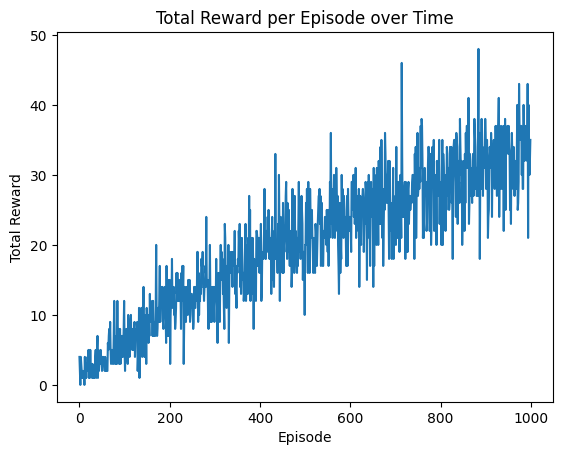

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from collections import deque

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize parameters
embedding_dim = 20  # Embedding dimension for entities and relations
K = 50  # Total number of entities (arms)
N_episodes = 1000  # Number of episodes
M = 100  # Number of steps per episode
batch_size = 32  # Batch size for replay buffer sampling
buffer_size = 1000  # Size of the replay buffer

# Generate entity and relation embeddings (move to device)
entity_embeddings = torch.tensor(np.random.randn(K, embedding_dim), dtype=torch.float32, device=device)
relation_embedding = torch.tensor(np.random.randn(embedding_dim), dtype=torch.float32, device=device)  # Only one relation "atLocation"

# True tail entities for each head entity
# This represents the correct tail for each head entity (randomly generated for now)
true_tail_entities = np.random.randint(0, K, size=K)

# Define the MLP Model with more complexity
class LinkPredictionMLP(nn.Module):
    def __init__(self, input_size):
        super(LinkPredictionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Increased neurons
        self.fc2 = nn.Linear(64, 32)  # Another hidden layer for more complexity
        self.fc3 = nn.Linear(32, 1)  # Output layer: predicts probability of reward

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output between 0 and 1 (probability)
        return x

# Initialize the MLP model
model = LinkPredictionMLP(input_size=embedding_dim * 3).to(device)  # Concatenate [head, relation, tail] embeddings
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary rewards
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Replay buffer to store experiences
replay_buffer = deque(maxlen=buffer_size)

# Function to generate binary reward based on whether the predicted tail is correct
def generate_reward(head_entity, predicted_tail):
    true_tail = true_tail_entities[head_entity]  # Get the true tail entity for the head
    return 1 if predicted_tail == true_tail else 0  # Reward is 1 if correct, else 0

# Function to select an action (tail entity) based on MLP predictions (epsilon-greedy)
def select_action(model, head_embedding, relation_embedding, tail_entities, epsilon=0.1):
    num_actions = tail_entities.shape[0]

    # Epsilon-greedy strategy: explore with probability epsilon, otherwise exploit
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Explore: choose a random entity
    else:
        # Exploit: choose the entity with the highest predicted reward
        with torch.no_grad():
            inputs = torch.cat([head_embedding.repeat(num_actions, 1), relation_embedding.repeat(num_actions, 1), tail_entities], dim=1)
            predictions = model(inputs)  # Predict reward probabilities for each entity
        return torch.argmax(predictions).item()

# Function to train the MLP model using a batch of experiences from the replay buffer
def train_model_batch(model, optimizer, replay_buffer):
    if len(replay_buffer) < batch_size:
        return  # Don't train until the buffer is filled enough

    # Sample a batch of experiences
    batch = random.sample(replay_buffer, batch_size)

    # Extract input vectors (concatenated [head, relation, tail]) and rewards
    batch_inputs = torch.stack([experience[0] for experience in batch]).to(device)  # Contexts (head, relation, tail)
    batch_rewards = torch.tensor([experience[1] for experience in batch], dtype=torch.float32, device=device)  # Rewards

    # Forward pass: predict rewards for each context in the batch
    model.train()
    predicted_rewards = model(batch_inputs)

    # Compute loss between predicted rewards and actual rewards
    loss = criterion(predicted_rewards, batch_rewards.unsqueeze(1))  # Unsqueeze to match dimensions

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize episode rewards storage
episode_rewards = []

# Epsilon parameters for decay
epsilon = 1.0  # Start with high exploration
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.999  # Slower decay to encourage more exploration

# Simulate N episodes
torch.manual_seed(42)
np.random.seed(42)
for episode in tqdm(range(N_episodes)):
    total_reward = 0  # Total reward for the episode

    for step in range(M):
        # Randomly select a head entity (e.g., Bob)
        head_entity = np.random.randint(0, K)
        head_embedding = entity_embeddings[head_entity].unsqueeze(0)  # Shape (1, embedding_dim)

        # Randomly select a set of candidate tail entities (e.g., Kitchen, Bathroom, etc.)
        tail_entity_indices = np.random.choice(K, np.random.randint(1, K+1), replace=False)
        tail_entity_embeddings = entity_embeddings[tail_entity_indices]

        # Select the best tail entity using epsilon-greedy strategy
        chosen_tail_index = select_action(model, head_embedding, relation_embedding.unsqueeze(0), tail_entity_embeddings, epsilon)
        chosen_tail_entity = tail_entity_indices[chosen_tail_index]

        # Generate binary reward (1 if correct, 0 if wrong)
        reward = generate_reward(head_entity, chosen_tail_entity)

        # Store the experience in the replay buffer (store the concatenation of [head, relation, tail])
        input_vector = torch.cat([head_embedding, relation_embedding.unsqueeze(0), entity_embeddings[chosen_tail_entity].unsqueeze(0)], dim=1).squeeze()
        replay_buffer.append((input_vector, reward))

        # Accumulate the reward for this episode
        total_reward += reward

        # Train the MLP model using a batch of experiences from the replay buffer
        train_model_batch(model, optimizer, replay_buffer)

    # Store the total reward for the current episode
    episode_rewards.append(total_reward)

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode over Time")
plt.show()


100%|██████████| 1000/1000 [01:30<00:00, 11.09it/s]


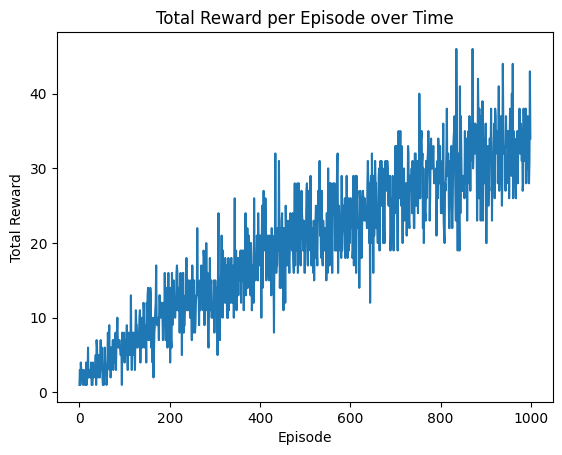

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from collections import deque

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize parameters
embedding_dim = 20  # Embedding dimension for entities and relations
K = 50  # Total number of entities (arms)
N_episodes = 1000  # Number of episodes
M = 100  # Number of steps per episode
batch_size = 32  # Batch size for replay buffer sampling
buffer_size = 1000  # Size of the replay buffer

# Generate entity and relation embeddings (move to device)
entity_embeddings = torch.tensor(np.random.randn(K, embedding_dim), dtype=torch.float32, device=device)
relation_embedding = torch.tensor(np.random.randn(embedding_dim), dtype=torch.float32, device=device)  # Only one relation "atLocation"

# True tail entities for each head entity
# This represents the correct tail for each head entity (randomly generated for now)
true_tail_entities = np.random.randint(0, K, size=K)

# Define the MLP Model with more complexity
class LinkPredictionMLP(nn.Module):
    def __init__(self, input_size):
        super(LinkPredictionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Increased neurons
        self.fc2 = nn.Linear(64, 32)  # Another hidden layer for more complexity
        self.fc3 = nn.Linear(32, 1)  # Output layer: predicts probability of reward

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output between 0 and 1 (probability)
        return x

# Initialize the MLP model
model = LinkPredictionMLP(input_size=embedding_dim * 3).to(device)  # Concatenate [head, relation, tail] embeddings
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary rewards
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Replay buffer to store experiences
replay_buffer = deque(maxlen=buffer_size)

# Function to generate binary reward based on whether the predicted tail is correct
def generate_reward(head_entity, predicted_tail):
    true_tail = true_tail_entities[head_entity]  # Get the true tail entity for the head
    return 1 if predicted_tail == true_tail else 0  # Reward is 1 if correct, else 0

# Function to select an action (tail entity) based on MLP predictions (epsilon-greedy)
def select_action(model, head_embedding, relation_embedding, tail_entities, epsilon=0.1):
    num_actions = tail_entities.shape[0]

    # Permute the tail entities randomly
    # This is just to see if this whole pipeline is actually permutation-invariant
    perm = torch.randperm(num_actions)
    tail_entities_permuted = tail_entities[perm]

    # Epsilon-greedy strategy: explore with probability epsilon, otherwise exploit
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Explore: choose a random entity
    else:
        # Exploit: choose the entity with the highest predicted reward
        with torch.no_grad():
            inputs = torch.cat([head_embedding.repeat(num_actions, 1), 
                                relation_embedding.repeat(num_actions, 1), 
                                tail_entities_permuted], dim=1)
            predictions = model(inputs)  # Predict reward probabilities for each entity
        
        # Get the predicted index in the permuted order
        predicted_index_permuted = torch.argmax(predictions).item()
        
        # Restore the original index by inverting the permutation
        predicted_index_original = perm[predicted_index_permuted].item()

        return predicted_index_original

# Function to train the MLP model using a batch of experiences from the replay buffer
def train_model_batch(model, optimizer, replay_buffer):
    if len(replay_buffer) < batch_size:
        return  # Don't train until the buffer is filled enough

    # Sample a batch of experiences
    batch = random.sample(replay_buffer, batch_size)

    # Extract input vectors (concatenated [head, relation, tail]) and rewards
    batch_inputs = torch.stack([experience[0] for experience in batch]).to(device)  # Contexts (head, relation, tail)
    batch_rewards = torch.tensor([experience[1] for experience in batch], dtype=torch.float32, device=device)  # Rewards

    # Forward pass: predict rewards for each context in the batch
    model.train()
    predicted_rewards = model(batch_inputs)

    # Compute loss between predicted rewards and actual rewards
    loss = criterion(predicted_rewards, batch_rewards.unsqueeze(1))  # Unsqueeze to match dimensions

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize episode rewards storage
episode_rewards = []

# Epsilon parameters for decay
epsilon = 1.0  # Start with high exploration
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.999  # Slower decay to encourage more exploration

# Simulate N episodes
torch.manual_seed(42)
np.random.seed(42)
for episode in tqdm(range(N_episodes)):
    total_reward = 0  # Total reward for the episode

    for step in range(M):
        # Randomly select a head entity (e.g., Bob)
        head_entity = np.random.randint(0, K)
        head_embedding = entity_embeddings[head_entity].unsqueeze(0)  # Shape (1, embedding_dim)

        # Randomly select a set of candidate tail entities (e.g., Kitchen, Bathroom, etc.)
        tail_entity_indices = np.random.choice(K, np.random.randint(1, K+1), replace=False)
        tail_entity_embeddings = entity_embeddings[tail_entity_indices]

        # Select the best tail entity using epsilon-greedy strategy
        chosen_tail_index = select_action(model, head_embedding, relation_embedding.unsqueeze(0), tail_entity_embeddings, epsilon)
        chosen_tail_entity = tail_entity_indices[chosen_tail_index]

        # Generate binary reward (1 if correct, 0 if wrong)
        reward = generate_reward(head_entity, chosen_tail_entity)

        # Store the experience in the replay buffer (store the concatenation of [head, relation, tail])
        input_vector = torch.cat([head_embedding, relation_embedding.unsqueeze(0), entity_embeddings[chosen_tail_entity].unsqueeze(0)], dim=1).squeeze()
        replay_buffer.append((input_vector, reward))

        # Accumulate the reward for this episode
        total_reward += reward

        # Train the MLP model using a batch of experiences from the replay buffer
        train_model_batch(model, optimizer, replay_buffer)

    # Store the total reward for the current episode
    episode_rewards.append(total_reward)

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode over Time")
plt.show()


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from collections import deque

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize parameters
embedding_dim = 20  # Embedding dimension for entities and relations
K = 50  # Total number of entities (arms)
N_episodes = 100  # Number of episodes
M = 100  # Number of steps per episode
batch_size = 32  # Batch size for replay buffer sampling
buffer_size = 1000  # Size of the replay buffer
noise_std = 0.1  # Standard deviation for the noise

# Generate entity and relation embeddings (move to device)
entity_embeddings = torch.tensor(
    np.random.randn(K, embedding_dim), dtype=torch.float32, device=device
)
relation_embedding = torch.tensor(
    np.random.randn(embedding_dim), dtype=torch.float32, device=device
)  # Only one relation "atLocation"

# True tail entities for each head entity
# This represents the correct tail for each head entity (randomly generated for now)
true_tail_entities = np.random.randint(0, K, size=K)


# Define the MLP Model with more complexity
class LinkPredictionMLP(nn.Module):
    def __init__(self, input_size):
        super(LinkPredictionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Increased neurons
        self.fc2 = nn.Linear(64, 32)  # Another hidden layer for more complexity
        self.fc3 = nn.Linear(32, 1)  # Output layer: predicts probability of reward

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output between 0 and 1 (probability)
        return x


# Initialize the MLP model
model = LinkPredictionMLP(input_size=embedding_dim * 3).to(
    device
)  # Concatenate [head, relation, tail] embeddings
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary rewards
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Replay buffer to store experiences
replay_buffer = deque(maxlen=buffer_size)


# Function to generate binary reward based on whether the predicted tail is correct
def generate_reward(head_entity, predicted_tail):
    true_tail = true_tail_entities[head_entity]  # Get the true tail entity for the head
    return 1 if predicted_tail == true_tail else 0  # Reward is 1 if correct, else 0


# Function to select an action (tail entity) based on MLP predictions (epsilon-greedy)
def select_action(
    model, head_embedding, relation_embedding, tail_entities, epsilon=0.1
):
    num_actions = tail_entities.shape[0]

    # Permute the tail entities randomly
    perm = torch.randperm(num_actions)
    tail_entities_permuted = tail_entities[perm]

    # Epsilon-greedy strategy: explore with probability epsilon, otherwise exploit
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Explore: choose a random entity
    else:
        # Exploit: choose the entity with the highest predicted reward
        with torch.no_grad():
            inputs = torch.cat(
                [
                    head_embedding.repeat(num_actions, 1),
                    relation_embedding.repeat(num_actions, 1),
                    tail_entities_permuted,
                ],
                dim=1,
            )
            predictions = model(inputs)  # Predict reward probabilities for each entity

        # Get the predicted index in the permuted order
        predicted_index_permuted = torch.argmax(predictions).item()

        # Restore the original index by inverting the permutation
        predicted_index_original = perm[predicted_index_permuted].item()

        return predicted_index_original


# Function to train the MLP model using a batch of experiences from the replay buffer
def train_model_batch(model, optimizer, replay_buffer):
    if len(replay_buffer) < batch_size:
        return  # Don't train until the buffer is filled enough

    # Sample a batch of experiences
    batch = random.sample(replay_buffer, batch_size)

    # Extract input vectors (concatenated [head, relation, tail]) and rewards
    batch_inputs = torch.stack([experience[0] for experience in batch]).to(
        device
    )  # Contexts (head, relation, tail)
    batch_rewards = torch.tensor(
        [experience[1] for experience in batch], dtype=torch.float32, device=device
    )  # Rewards

    # Forward pass: predict rewards for each context in the batch
    model.train()
    predicted_rewards = model(batch_inputs)

    # Compute loss between predicted rewards and actual rewards
    loss = criterion(
        predicted_rewards, batch_rewards.unsqueeze(1)
    )  # Unsqueeze to match dimensions

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


# Initialize episode rewards storage
episode_rewards = []

# Epsilon parameters for decay
epsilon = 1.0  # Start with high exploration
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.999  # Slower decay to encourage more exploration

# Simulate N episodes
torch.manual_seed(42)
np.random.seed(42)
for episode in tqdm(range(N_episodes)):
    total_reward = 0  # Total reward for the episode

    for step in range(M):
        # Randomly select a head entity (e.g., Bob)
        head_entity = np.random.randint(0, K)
        head_embedding = entity_embeddings[head_entity].unsqueeze(
            0
        )  # Shape (1, embedding_dim)

        # Add noise to head_embedding
        head_embedding_noisy = head_embedding + noise_std * torch.randn_like(
            head_embedding
        )

        # Randomly select a set of candidate tail entities (e.g., Kitchen, Bathroom, etc.)
        tail_entity_indices = np.random.choice(
            K, np.random.randint(1, K + 1), replace=False
        )
        tail_entity_embeddings = entity_embeddings[tail_entity_indices]

        # Add noise to each tail entity embedding
        tail_entity_embeddings_noisy = (
            tail_entity_embeddings
            + noise_std * torch.randn_like(tail_entity_embeddings)
        )

        # Select the best tail entity using epsilon-greedy strategy
        chosen_tail_index = select_action(
            model,
            head_embedding_noisy,
            relation_embedding.unsqueeze(0),
            tail_entity_embeddings_noisy,
            epsilon,
        )
        chosen_tail_entity = tail_entity_indices[chosen_tail_index]

        # Generate binary reward (1 if correct, 0 if wrong)
        reward = generate_reward(head_entity, chosen_tail_entity)

        # Store the experience in the replay buffer (store the concatenation of [head, relation, tail])
        input_vector = torch.cat(
            [
                head_embedding_noisy,
                relation_embedding.unsqueeze(0),
                entity_embeddings[chosen_tail_entity].unsqueeze(0),
            ],
            dim=1,
        ).squeeze()
        replay_buffer.append((input_vector, reward))

        # Accumulate the reward for this episode
        total_reward += reward

        # Train the MLP model using a batch of experiences from the replay buffer
        train_model_batch(model, optimizer, replay_buffer)

    # Store the total reward for the current episode
    episode_rewards.append(total_reward)

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode over Time")
plt.show()

/home/tk/.virtualenvs/agent-room-env-v2-qa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  8%|▊         | 8/100 [00:00<00:08, 10.65it/s]


KeyboardInterrupt: 

In [17]:
foo = torch.randn(3)

foo

tensor([-0.0574,  0.9695,  0.2606])

In [25]:
foo.repeat(3, 1)

tensor([[-0.0574,  0.9695,  0.2606],
        [-0.0574,  0.9695,  0.2606],
        [-0.0574,  0.9695,  0.2606]])

In [9]:
batch = random.sample(replay_buffer, batch_size)
len(batch)

32

In [7]:
# Extract input vectors (concatenated [head, relation, tail]) and rewards
batch_inputs = torch.stack([experience[0] for experience in batch]).to(
    device
)  # Contexts (head, relation, tail)

In [8]:
batch_inputs.shape

torch.Size([32, 60])

100%|██████████| 100/100 [00:08<00:00, 12.34it/s]


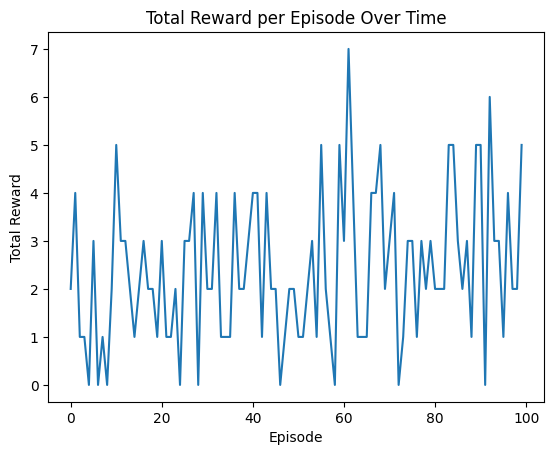

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize parameters
embedding_dim = 20  # Embedding dimension for entities and relations
K = 50  # Total number of entities (arms)
N_episodes = 100  # Number of episodes
M = 100  # Number of steps per episode
noise_std = 0.1  # Standard deviation for the noise

# Generate entity and relation embeddings (move to device)
entity_embeddings = torch.tensor(np.random.randn(K, embedding_dim), dtype=torch.float32, device=device)
relation_embedding = torch.tensor(np.random.randn(embedding_dim), dtype=torch.float32, device=device)  # Only one relation "atLocation"

# True tail entities for each head entity
# This represents the correct tail for each head entity (randomly generated for now)
true_tail_entities = np.random.randint(0, K, size=K)

# Define the MLP Model with more complexity
class LinkPredictionMLP(nn.Module):
    def __init__(self, input_size):
        super(LinkPredictionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Increased neurons
        self.fc2 = nn.Linear(64, 32)  # Another hidden layer for more complexity
        self.fc3 = nn.Linear(32, 1)  # Output layer: predicts probability of reward

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output between 0 and 1 (probability)
        return x

# Initialize the MLP model
model = LinkPredictionMLP(input_size=embedding_dim * 3).to(device)  # Concatenate [head, relation, tail] embeddings
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary rewards
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to generate binary reward based on whether the predicted tail is correct
def generate_reward(head_entity, predicted_tail):
    true_tail = true_tail_entities[head_entity]  # Get the true tail entity for the head
    return 1 if predicted_tail == true_tail else 0  # Reward is 1 if correct, else 0

# Function to select an action (tail entity) based on MLP predictions (epsilon-greedy)
def select_action(model, head_embedding, relation_embedding, tail_entities, epsilon=0.1):
    num_actions = tail_entities.shape[0]

    # Permute the tail entities randomly
    perm = torch.randperm(num_actions)
    tail_entities_permuted = tail_entities[perm]

    # Epsilon-greedy strategy: explore with probability epsilon, otherwise exploit
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Explore: choose a random entity
    else:
        # Exploit: choose the entity with the highest predicted reward
        with torch.no_grad():
            inputs = torch.cat(
                [head_embedding.repeat(num_actions, 1), 
                 relation_embedding.repeat(num_actions, 1), 
                 tail_entities_permuted], dim=1)
            predictions = model(inputs)  # Predict reward probabilities for each entity
        
        # Get the predicted index in the permuted order
        predicted_index_permuted = torch.argmax(predictions).item()

        # Restore the original index by inverting the permutation
        predicted_index_original = perm[predicted_index_permuted].item()

        return predicted_index_original

# Function to train the MLP model online (update after each experience)
def train_model_online(model, optimizer, input_vector, reward):
    # Forward pass: predict reward for the current context
    model.train()
    predicted_reward = model(input_vector.unsqueeze(0))  # Add batch dimension (1, input_size)
    
    # Compute loss between predicted reward and actual reward
    reward_tensor = torch.tensor([[reward]], dtype=torch.float32, device=device)
    loss = criterion(predicted_reward, reward_tensor)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize episode rewards storage
episode_rewards = []

# Epsilon parameters for decay
epsilon = 1.0  # Start with high exploration
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.999  # Slower decay to encourage more exploration

# Simulate N episodes
torch.manual_seed(42)
np.random.seed(42)
for episode in tqdm(range(N_episodes)):
    total_reward = 0  # Total reward for the episode

    for step in range(M):
        # Randomly select a head entity (e.g., Bob)
        head_entity = np.random.randint(0, K)
        head_embedding = entity_embeddings[head_entity].unsqueeze(0)  # Shape (1, embedding_dim)

        # Add noise to head_embedding
        head_embedding_noisy = head_embedding + noise_std * torch.randn_like(head_embedding)

        # Randomly select a set of candidate tail entities (e.g., Kitchen, Bathroom, etc.)
        tail_entity_indices = np.random.choice(K, np.random.randint(1, K + 1), replace=False)
        tail_entity_embeddings = entity_embeddings[tail_entity_indices]

        # Add noise to each tail entity embedding
        tail_entity_embeddings_noisy = tail_entity_embeddings + noise_std * torch.randn_like(tail_entity_embeddings)

        # Select the best tail entity using epsilon-greedy strategy
        chosen_tail_index = select_action(model, head_embedding_noisy, relation_embedding.unsqueeze(0), tail_entity_embeddings_noisy, epsilon)
        chosen_tail_entity = tail_entity_indices[chosen_tail_index]

        # Generate binary reward (1 if correct, 0 if wrong)
        reward = generate_reward(head_entity, chosen_tail_entity)

        # Prepare input vector for the model (concatenation of [head, relation, tail])
        input_vector = torch.cat(
            [head_embedding_noisy, relation_embedding.unsqueeze(0), entity_embeddings[chosen_tail_entity].unsqueeze(0)], dim=1).squeeze()

        # Online training: update the model with this single experience
        train_model_online(model, optimizer, input_vector, reward)

        # Accumulate the reward for this episode
        total_reward += reward

    # Store the total reward for the current episode
    episode_rewards.append(total_reward)

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot the episode rewards to see if the model is learning over time
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode Over Time")
plt.show()


In [5]:
{"a": 1} == {"a": 1, }

True